<a href="https://colab.research.google.com/github/juanpeter-yuune/email_spam_using_BERT/blob/master/BERT_email_classification_handle_imbalance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow==2.15.0 tensorflow-hub==0.16.1 tensorflow-text==2.15.0

<h2 align="center">BERT tutorial: Classify spam vs no spam emails</h2>

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from matplotlib import pyplot as plt
import seaborn as sn
from sklearn.metrics import classification_report, confusion_matrix, matthews_corrcoef, roc_auc_score

<h4>Import the dataset (Dataset is taken from kaggle)</h4>

In [3]:
df = pd.read_csv("emailspam.csv")
df.head(5)

,Category,Message
0,"ham,""Go until jurong point, crazy.. Available ...",NaN
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,"ham,""Nah I don't think he goes to usf, he live...",NaN


In [4]:
df.groupby('Category').describe()

Message         \
                                                     count unique   
Category                                                            
 here's a special discount code for your next p...       1      1   
 please contact us immediately.                          1      1   
 thank you for subscribing to our newsletter. H...       1      1   
 we'll achieve great things!                             1      1   
 we'll make a difference!                                1      1   
...                                                    ...    ...   
spam,"ou are guaranteed the latest Nokia Phone,...       0      0   
spam,"our mobile number has won Â£5000, to clai...       0      0   
spam,"pdate_Now - Double mins and 1000 txts on ...       0      0   
spam,"tddnewsletter@emc1.co.uk (More games from...       0      0   
spam,"u r subscribed 2 TEXTCOMP 250 wkly comp. ...       0      0   

                                                                                                       \
                                                                                                  top   
Category                                                                                                
 here's a special discount code for your next p...                               Dear valued customer   
 please contact us immediately.                     Your account login was successful. If this was...   
 thank you for subscribing to our newsletter. H...                                        Dear [Name]   
 we'll achieve great things!                        We're pleased to announce our partnership with...   
 we'll make a difference!                           We're thrilled to announce our partnership wit...   
...                                                                                               ...   
spam,"ou are guaranteed the latest Nokia Phone,...                                                NaN   
spam,"our mobile number has won Â£5000, to clai...                                                NaN   
spam,"pdate_Now - Double mins and 1000 txts on ...                                                NaN   
spam,"tddnewsletter@emc1.co.uk (More games from...                                                NaN   
spam,"u r subscribed 2 TEXTCOMP 250 wkly comp. ...                                                NaN   

                                                         
                                                   freq  
Category                                                 
 here's a special discount code for your next p...    1  
 please contact us immediately.                       1  
 thank you for subscribing to our newsletter. H...    1  
 we'll achieve great things!                          1  
 we'll make a difference!                             1  
...                                                 ...  
spam,"ou are guaranteed the latest Nokia Phone,...  NaN  
spam,"our mobile number has won Â£5000, to clai...  NaN  
spam,"pdate_Now - Double mins and 1000 txts on ...  NaN  
spam,"tddnewsletter@emc1.co.uk (More games from...  NaN  
spam,"u r subscribed 2 TEXTCOMP 250 wkly comp. ...  NaN  

[1237 rows x 4 columns]

In [5]:
df['Category'].value_counts()

,count
Category,
ham,3778
spam,577
"ham,""Sorry, I'll call later""",29
"ham,""Say this slowly.? GOD,I LOVE YOU &amp",4
"ham,""7 wonders in My WORLD 7th You 6th Ur style 5th Ur smile 4th Ur Personality 3rd Ur Nature 2nd Ur SMS and 1st """"Ur Lovely Friendship""""... good morning dear""",4
...,...
"ham,""Its ok chikku, and its my 1 of favourite song..:-)""",1
"ham,""I'm not coming over, do whatever you want""",1
"ham,""Good afternoon sexy buns! How goes the job search ? I wake and you are my first thought as always, my love. I wish your fine and happy and know I adore you!""",1


In [6]:
747/4825

0.15481865284974095

**15% spam emails, 85% ham emails: This indicates class imbalance**

In [7]:
df_spam = df[df['Category']=='spam']
df_spam.shape

(577, 2)

In [8]:
df_ham = df[df['Category']=='ham']
df_ham.shape

(3778, 2)

In [9]:
df_ham_downsampled = df_ham.sample(df_spam.shape[0])
df_ham_downsampled.shape

(577, 2)

In [10]:
df_balanced = pd.concat([df_ham_downsampled, df_spam])
df_balanced.shape

(1154, 2)

In [11]:
df_balanced['Category'].value_counts()

,count
Category,
ham,577
spam,577


In [12]:
df_balanced['spam']=df_balanced['Category'].apply(lambda x: 1 if x=='spam' else 0)
df_balanced.sample(5)

,Category,Message,spam
5044,spam,Free video camera phones with Half Price line ...,1
3942,ham,I got to video tape pple type in message lor. ...,0
222,ham,U say leh... Of course nothing happen lar. Not...,0
764,spam,UR awarded a City Break and could WIN a Â£200 ...,1
4367,ham,yeah sure thing mate haunt got all my stuff so...,0


<h4>Split it into training and test data set</h4>

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_balanced['Message'],df_balanced['spam'], stratify=df_balanced['spam'])

In [16]:
# Count the number of samples in each class for the training set
train_counts = y_train.value_counts()
print("Training data class distribution:")
print(train_counts)

# Count the number of samples in each class for the testing set
test_counts = y_test.value_counts()
print("\nTesting data class distribution:")
print(test_counts)


Training data class distribution:
spam
1    433
0    432
Name: count, dtype: int64

Testing data class distribution:
spam
0    145
1    144
Name: count, dtype: int64


In [17]:
X_train.head(4)

,Message
5286,I can't make it tonight
174,Let me know when you've got the money so carlo...
1454,Summers finally here! Fancy a chat or flirt wi...
1089,WIN URGENT! Your mobile number has been awarde...


<h4>Now lets import BERT model and get embeding vectors for few sample statements</h4>

In [18]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [19]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

get_sentence_embeding([
    "500$ discount. hurry up",
    "Bhavin, are you up for a volleybal game tomorrow?"]
)

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.84351707, -0.51327246, -0.8884571 , ..., -0.7474883 ,
        -0.75314736,  0.91964495],
       [-0.8720835 , -0.50543964, -0.9444668 , ..., -0.8584751 ,
        -0.7174534 ,  0.88082975]], dtype=float32)>

<h4>Get embeding vectors for few sample words. Compare them using cosine similarity</h4>

"exclusive deal",
    "limited time offer",
    "act now",
    "urgent",
    "money",
    "cash",
    "investment",
    "guaranteed",
    "make money",
    "credit card",
    "debt relief",
    "account",
    "login",
    "verify",
    "update",
    "risk-free",
    "trial",
    "satisfaction guaranteed",
    "meeting",
    "project",
    "update",
    "collaboration",
    "report",
    "schedule",
    "hello",
    "thank you",
    "regards",
    "please",
    "feedback",
    "follow-up",
    "contract",
    "invoice",
    "purchase order",
    "quote",
    "resume",
    "email",
    "message",
    "reply",
    "information",
    "data",
    "send",
    "receive",
    "ask",
    "call",
    "security alert",
    "your payment",
    "unsubscribe",

In [24]:
e = get_sentence_embeding([
    "free",
    "winner",
    "click here",
    "exclusive deal",
    "limited time offer",
    "act now",
    "urgent",
    "money",
    "cash",
    "investment",
    "guaranteed",
    "make money",
    "credit card",
    "debt relief",
    "account",
    "login",
    "verify",
    "update",
    "risk-free",
    "trial",
    "satisfaction guaranteed",
    "meeting",
    "project",
    "update",
    "collaboration",
    "report",
    "schedule",
    "hello",
    "thank you",
    "regards",
    "please",
    "feedback",
    "follow-up",
    "contract",
    "invoice",
    "purchase order",
    "quote",
    "resume",
    "email",
    "message",
    "reply",
    "information",
    "data",
    "send",
    "receive",
    "ask",
    "call",
    "security alert",
    "your payment",
    "unsubscribe",
    "spam"
]
)

In [25]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity([e[0]],[e[1]])

array([[0.96217227]], dtype=float32)

Values near to 1 means they are similar. 0 means they are very different.
Above you can use comparing "banana" vs "grapes" you get 0.99 similarity as they both are fruits

In [26]:
cosine_similarity([e[0]],[e[3]])

array([[0.8173282]], dtype=float32)

Comparing banana with jeff bezos you still get 0.84 but it is not as close as 0.99 that we got with grapes

In [27]:
cosine_similarity([e[3]],[e[4]])

array([[0.9930565]], dtype=float32)

Jeff bezos and Elon musk are more similar then Jeff bezos and banana as indicated above

<h4>Build Model</h4>

There are two types of models you can build in tensorflow.

(1) Sequential
(2) Functional

So far we have built sequential model. But below we will build functional model. More information on these two is here: https://becominghuman.ai/sequential-vs-functional-model-in-keras-20684f766057

In [28]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])



https://stackoverflow.com/questions/47605558/importerror-failed-to-import-pydot-you-must-install-pydot-and-graphviz-for-py

In [29]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 keras_layer_2 (KerasLayer)  {'input_word_ids': (None,    0         ['text[0][0]']                
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             , 'input_type_ids': (None,                                           
                              128)}                                                               
                                                                                              

In [30]:
len(X_train)

865

In [47]:
# Custom specificity metric
def specificity(y_true, y_pred):
    true_negatives = tf.math.reduce_sum(tf.cast((y_true == 0) & (y_pred < 0.5), tf.float32))
    false_positives = tf.math.reduce_sum(tf.cast((y_true == 0) & (y_pred >= 0.5), tf.float32))
    specificity_value = true_negatives / (true_negatives + false_positives + tf.keras.backend.epsilon())
    return specificity_value

# Custom MCC metric
def matthews_correlation_coefficient(y_true, y_pred):
    y_pred_pos = tf.round(y_pred)
    y_pred_neg = 1 - y_pred_pos

    y_true_pos = tf.round(y_true)
    y_true_neg = 1 - y_true_pos

    tp = tf.reduce_sum(y_true_pos * y_pred_pos)
    tn = tf.reduce_sum(y_true_neg * y_pred_neg)

    fp = tf.reduce_sum(y_true_neg * y_pred_pos)
    fn = tf.reduce_sum(y_true_pos * y_pred_neg)

    numerator = (tp * tn) - (fp * fn)
    denominator = tf.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

    mcc = numerator / (denominator + tf.keras.backend.epsilon())
    return mcc



<h4>Train the model</h4>

In [48]:
# Compile model with custom metrics
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),  # Sensitivity
    tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.AUC(name='prc', curve='PR'),  # Precision-Recall AUC (optional)
    specificity,  # Custom specificity metric
    matthews_correlation_coefficient  # Custom MCC metric
]

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=METRICS)

# Train the model and store the history
history = model.fit(X_train, y_train, epochs=10)

# Print the performance metrics from the history
for metric in history.history:
    print(f'{metric}: {history.history[metric][-1]}')

Epoch 1/10
28/28 [==============================] - 40s 1s/step - loss: 0.2262 - accuracy: 0.9225 - precision: 0.9197 - recall: 0.9261 - auc: 0.9740 - prc: 0.9753 - specificity: 0.9227 - matthews_correlation_coefficient: 0.8139
Epoch 2/10
28/28 [==============================] - 37s 1s/step - loss: 0.2253 - accuracy: 0.9168 - precision: 0.9020 - recall: 0.9353 - auc: 0.9739 - prc: 0.9759 - specificity: 0.9054 - matthews_correlation_coefficient: 0.8059
Epoch 3/10
28/28 [==============================] - 37s 1s/step - loss: 0.2172 - accuracy: 0.9353 - precision: 0.9435 - recall: 0.9261 - auc: 0.9774 - prc: 0.9789 - specificity: 0.9149 - matthews_correlation_coefficient: 0.8393
Epoch 4/10
28/28 [==============================] - 37s 1s/step - loss: 0.2076 - accuracy: 0.9364 - precision: 0.9276 - recall: 0.9469 - auc: 0.9789 - prc: 0.9810 - specificity: 0.8937 - matthews_correlation_coefficient: 0.8409
Epoch 5/10
28/28 [==============================] - 37s 1s/step - loss: 0.2046 - accurac

In [50]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

10/10 [==============================] - 13s 1s/step


In [51]:
y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0,
       0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1,
       0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1,
       1, 1, 0])

In [52]:
cm = confusion_matrix(y_test, y_predicted)
cm

array([[134,  11],
       [  8, 136]])

Text(50.722222222222214, 0.5, 'Truth')

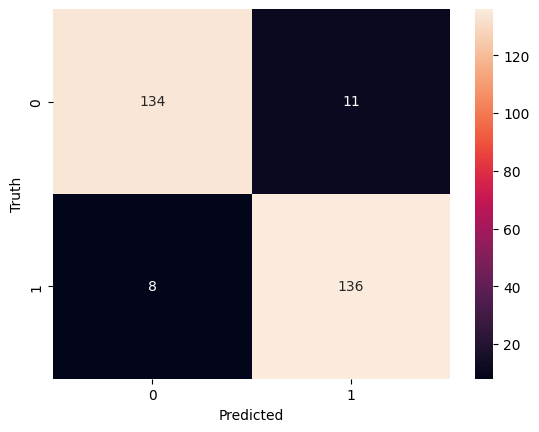

In [53]:
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

<h4>Inference</h4>

In [54]:
reviews = [
    'Enter a chance to win $5000, hurry up, offer valid until march 31, 2021',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your ."
]
model.predict(reviews)

1/1 [==============================] - 1s 1s/step


array([[0.8685452 ],
       [0.9022469 ],
       [0.8178047 ],
       [0.260215  ],
       [0.07107309]], dtype=float32)

In [55]:
# Save the entire model to a HDF5 file or SavedModel format
model.save('your_model_name.h5')  # HDF5 format
# or
model.save('your_model_name')  # SavedModel format (recommended)


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
